In [ ]:
#default_exp training
#all_slow

In [2]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/noise2noise

/content/drive/MyDrive/noise2noise


In [23]:
%reload_ext autoreload

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#hide
#run to export library
from nbdev.export import notebook2script; notebook2script()

In [24]:
#export
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from noise2noise.helpers import *

In [8]:
from noise2noise.unet import *

# Training

> Training pipeline

In [9]:
#export
class ToFloatImage:

    def __init__(self):
       pass

    def __call__(self, img):
        return to_float_image(img)

In [10]:
to_image = transforms.Compose(
    [
        ToFloatImage()
    ]
)

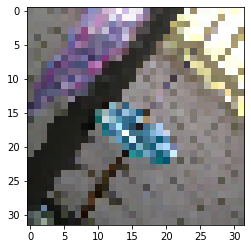

In [11]:
noisy_imgs_1 , noisy_imgs_2 = load_images()
img = noisy_imgs_1[0]
show_img(to_image(img))

In [12]:
#export
class Noise2NoiseDataset(Dataset):
    def __init__(self, img_path, transform=None, target_transform=None, input_target_transforms = None, nb_samples=None):
        
        self.imgs, self.targets = load_images(img_path)
        self.transform = transform
        self.target_transform = target_transform
        self.input_target_transforms = input_target_transforms
        self.nb_samples = nb_samples
    

    def __len__(self):
        return  self.nb_samples if self.nb_samples else len(self.imgs)

    def __getitem__(self, idx):
        image, target = self.imgs[idx], self.targets[idx]
     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        if self.input_target_transforms:
            image, target = self.input_target_transforms((image,target))
        
        return image, target

In [19]:
#export
def psnr_metric():
    return lambda denoised , ground_truth: psnr(denoised.clip(0,1) , ground_truth, single=False)

[autoreload of noise2noise.helpers failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/drive/MyDrive/noise2noise/noise2noise/helpers.py", line 40
    mse = torch.mean(( denoised - ground_truth ) ** 2, dim=[[1,2,3])
                                                                   ^
SyntaxError: invalid syntax
]


In [14]:
#export
def train(model, 
          train_loader, 
          test_loader, 
          optim, 
          criterion, 
          metric, 
          gradient_steps=1000, 
          samples_steps=100,
          lr_scheduler=None,
          lr_steps=1):
    iterator = iter(train_loader)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train_loss = []
    test_loss = []
    test_metric = []
    
    
    for steps in tqdm(range(gradient_steps)):
       
        input, target = None, None
        try:
            input, target = iterator.next()
        except StopIteration:
            iterator = iter(train_loader)
            input, target = iterator.next()
        input, target = input.to(device), target.to(device)
        output = model(input)
        loss = criterion(output, target)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if (steps+1)%samples_steps==0:
          
            if train_loader:
              train_loss.append((steps, eval_model(model, train_loader, criterion, max_iter=5)))
            if test_loader:
              test_loss.append((steps, eval_model(model, test_loader, criterion)))
              test_metric.append((steps,eval_model(model, test_loader, metric)))

        if lr_scheduler and (steps+1)%lr_steps==0:
          lr_scheduler.step()

            
    return train_loss, test_loss, test_metric
         
    


def eval_model(model, loader, metric, max_iter=None):
    losses = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
 
    with torch.no_grad():
        for i, (input, target) in enumerate(iter(loader)):
    
            input, target = input.to(device), target.to(device)
            output = model(input)
            losses.append(metric(output, target).item())
          
            
            if max_iter and i>=max_iter:
                break
            
            
    return sum(losses)/len(losses)

In [26]:
from torch.optim import Adam

unet = Unet()
optim = Adam(unet.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.1)
criterion = nn.MSELoss()
metric = psnr_metric()

train_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/train_data.pkl', transform=to_image, target_transform=to_image ),
    batch_size = 64,
    num_workers = 4,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

test_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', transform=to_image, target_transform=to_image ),
    batch_size = 64,
    num_workers = 4,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=20, 
                                           samples_steps=5,
                                           lr_scheduler=scheduler,
                                           lr_steps=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 20/20 [02:28<00:00,  7.42s/it]


In [27]:
#export
#hide
def row(i, nb_cols):
    return i//nb_cols
def col(i, nb_cols):
    return (i%nb_cols)*2
    

In [28]:
#export

def show_results(model, dataloader, nb_cols=3, nb_rows=2):
    _, axis = plt.subplots(nb_rows,nb_cols*2, figsize=(nb_cols*6,3*nb_cols))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    input, target = iter(dataloader).next()
    model.to("cpu")
    
    with torch.no_grad():
        output = model(input)
        nb_examples = nb_cols*nb_rows

        
        
        for i in range(min(nb_examples, len(output))):
            r, c = row(i,nb_cols), col(i, nb_cols)
            axis[r,c].set_title(f'psnr :{psnr(output[i] , target[i]).item():.{4}f}')
            show_img(output[i], axis=axis[r,c])
            show_img(target[i], axis=axis[r,c+1])
    model.to(device)

    
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


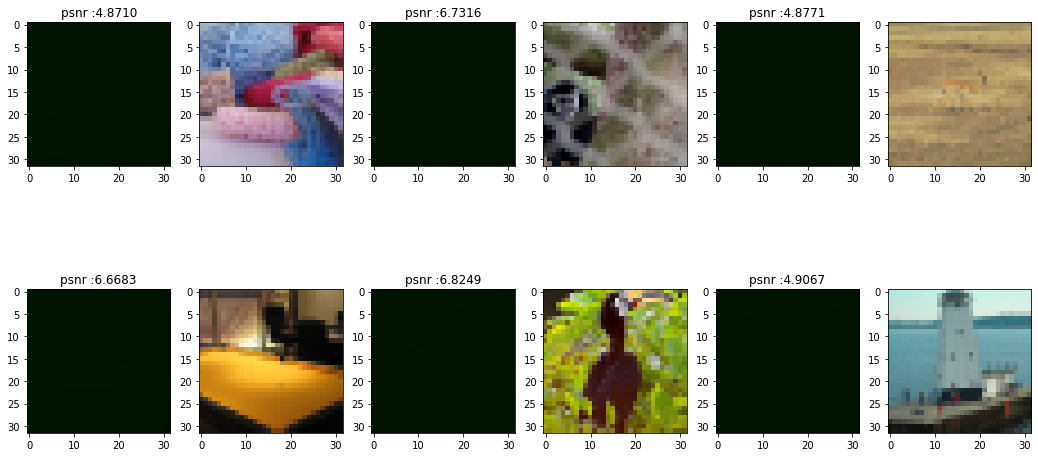

In [29]:
show_results(unet, test_loader)

In [32]:
#export

def show_worst(model, dataloader, nb_cols=3, nb_rows=2):
    _, axis = plt.subplots(nb_rows,nb_cols*2, figsize=(nb_cols*6,3*nb_cols))
    nb_examples = nb_cols*nb_rows
    psnrs = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    
    with torch.no_grad():
        for input, target in iter(dataloader):
            input, target = input.to(device), target.to(device)
            output = model(input)
            for i, p in enumerate(psnr(output , target, single=False, average=False)):
                psnrs.append((p,(output[i],target[i])))
           
            
    psnrs.sort(key=lambda x:x[0])
    for i in range(min(nb_examples, len(output))):
            r, c = row(i,nb_cols), col(i, nb_cols)
            p, (output,target) = psnrs[i][0], psnrs[i][1]
            axis[r,c].set_title(f'psnr :{p:.{4}f}')
            show_img(output.to("cpu"), axis=axis[r,c])
            show_img(target.to("cpu"), axis=axis[r,c+1])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


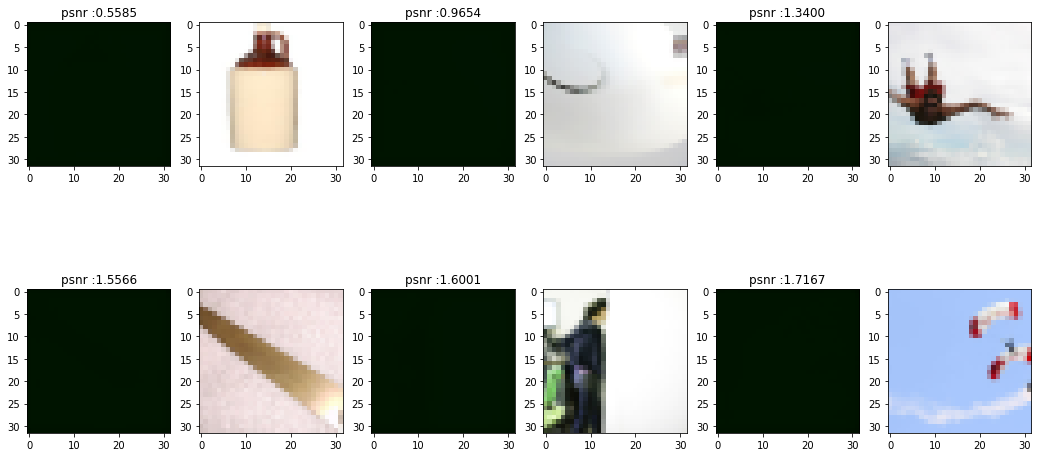

In [33]:
show_worst(unet, test_loader, nb_cols=3, nb_rows=2)

In [34]:
#export

def plot_psnr_distribution(model, dataloader):
    psnrs = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    
    with torch.no_grad():
        for input, target in iter(dataloader):
            input, target = input.to(device), target.to(device)
            output = model(input)
            psnrs.extend(psnr(output , target, single=False, average=False).tolist())
    plt.hist(psnrs, bins=30)
    plt.xlabel('psnr')
    plt.ylabel('number images')
        

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


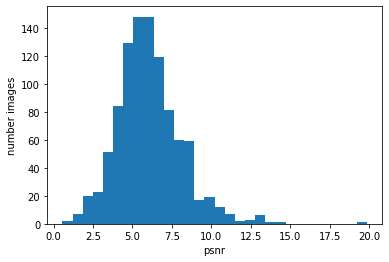

In [35]:
plot_psnr_distribution(unet, test_loader)

In [ ]:
#export
def plot_psnr(psnrs, labels, axis):
    for psnr, label in zip(psnrs,labels):
        steps, psnr = zip(*psnr)
        axis.plot(steps, psnr, label=label)
    
   
    axis.set_xlabel('gradient steps')
    axis.legend()
    axis.set_ylabel('psnr')

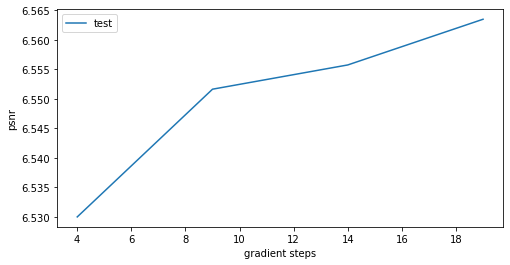

In [ ]:
_, axs = plt.subplots(figsize=(8,4))
plot_psnr([test_metric], ['test'], axs)

In [ ]:
#export
def plot_losses(train_losses, test_losses, test_metric):
    _, (loss_axis, metric_axis) = plt.subplots(1,2, figsize=(16,4))
    steps, train_losses = zip(*train_losses)
    _, test_losses = zip(*test_losses)
    _, test_metric = zip(*test_metric)
    
    loss_axis.plot(steps, train_losses,color='black',label='train')
    loss_axis.plot(steps, test_losses,color='grey',label='test')
    loss_axis.set_ylabel('mse')
    loss_axis.set_xlabel('gradient steps')
    loss_axis.legend()
    
    
    metric_axis.plot(steps, test_metric,color='grey', label='test')
    metric_axis.set_xlabel('gradient steps')
    metric_axis.legend()
    metric_axis.set_ylabel('psnr')

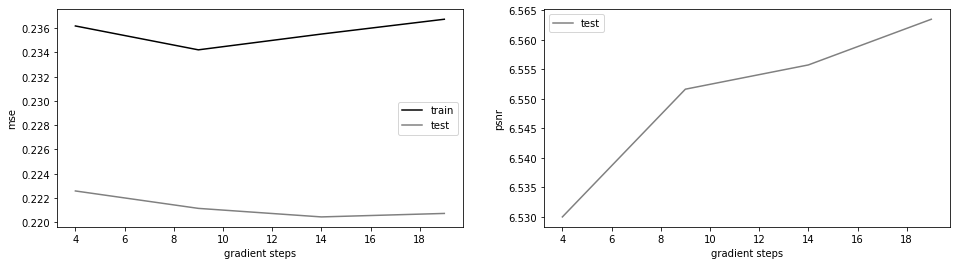

In [ ]:
plot_losses(train_loss, test_loss, test_metric)

In [ ]:
#export

def lr_finder(model, loader, optim_class, criterion, gradient_steps=1000, samples_steps=100, lr_steps=10):
  lr_steps = gradient_steps//lr_steps
  lr = 1e-8

  optim = optim_class(model.parameters(), lr=lr)
  lrs = torch.logspace(-8,0,lr_steps)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lambda x: lrs[x]/1e-8)

  losses, _, _ = train(model, loader, None, optim, criterion, None, 
          gradient_steps=gradient_steps, 
          samples_steps=samples_steps,
          lr_scheduler=scheduler,
          lr_steps=10)
  
 
  _, losses = zip(*losses)
  idxs = torch.logspace(-8,0,gradient_steps//samples_steps)[1:]
  plt.plot(idxs,list(losses))
  plt.xscale('log')
  plt.xlabel('lr rate')
  plt.ylabel('loss')
  

In [ ]:
unet = Unet()
criterion = nn.MSELoss()


lr_finder(unet, train_loader, Adam, criterion, gradient_steps=10, samples_steps=1, lr_steps=1)